#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [92]:
import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=cuda0,optimizer=fast_compile'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import importlib
from sklearn.inspection import permutation_importance
# import category_encoders as ce
# from catboost import CatBoostRegressor, Pool
import arviz as az
import pymc3 as pm
import theano
import bambi as bmb
import theano.tensor as tt
from sklearn import preprocessing
# import shap
import mkl
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions
import xarray
from sklearn.metrics import mean_squared_error
from pymc3.variational.callbacks import CheckParametersConvergence


# %load_ext timeit
# %load_ext heat
# %load_ext line_profiler
# %load_ext memory_profiler

In [93]:
df = pd.read_csv('C:/Users/norri/Desktop/tyson_update.csv')
df_bu = df
df.describe()
df.info()

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0,1,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59003 entries, 0 to 59002
Data columns (total 77 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Product                                           4964 non-null   object 
 1   Geography                                         4964 non-null   object 
 2   Dollar Sales                                      4750 non-null   float64
 3   Dollar Sales No Merch                             4650 non-null   float64
 4   Dollar Sales Any Merch                            4746 non-null   float64
 5   Dollar Sales Price Reductions Only                4643 non-null   float64
 6   Dollar Sales Feature Only                         2527 non-null   float64
 7   Dollar Sales Display Only                         3671 non-null   float64
 8   Dollar Sales Feature and Display                  2261 non-null   float64
 9   Dollar Sales Feat

Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or ped altogether

##### The following few sections analyze categorical, float, and int variables
##### so the dataset can be cleaned

In [94]:
df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date',
              'Tactic End Date'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 6 categorical variables

The categorical variables are :

 ['Product', 'Geography', 'Time', 'Brand', 'Tactic Category', 'RMN']
Product            0.915869
Geography          0.915869
Time               0.915869
Brand              0.000000
Tactic Category    0.000000
RMN                0.000000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59003 entries, 0 to 59002
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product          4964 non-null   object
 1   Geography        4964 non-null   object
 2   Time             4964 non-null   object
 3   Brand            59003 non-null  object
 4   Tactic Category  59003 non-null  object
 5   RMN              59003 non-null  object
dtypes: object(6)
memory usage: 2.7+ MB
Product            42
Geography          10
Time               66
Brand              97
Tactic Category    20
RMN                 2
dtype: int64


In [95]:
df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

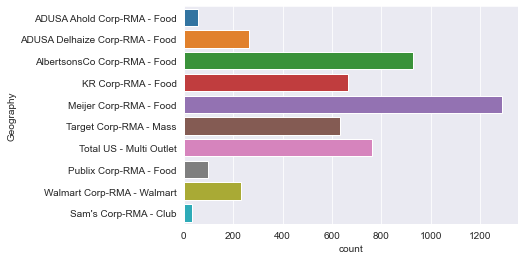

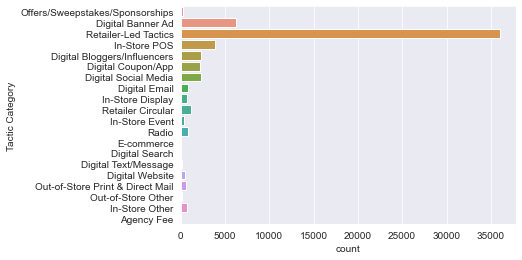

In [96]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [97]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 9 integer variables

The integer variables are :

 ['ClientId', 'Program Id', 'TacticId', 'CategoryId', 'Total Impressions for Tactic', 'BrandId', 'Nielsen_Week_Year', 'RMN', 'Weeks']
ClientId                        0
Program Id                      0
TacticId                        0
CategoryId                      0
Total Impressions for Tactic    0
BrandId                         0
Nielsen_Week_Year               0
RMN                             0
Weeks                           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59003 entries, 0 to 59002
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   ClientId                      59003 non-null  int64
 1   Program Id                    59003 non-null  int64
 2   TacticId                      59003 non-null  int64
 3   CategoryId                    59003 non-null  int64
 4   Total Impressions for Tactic  59

##### In the below section we address the large number of missing s and also
##### the columns consisting entirely of zeroes, and drop them accordingly

In [98]:
# df = df.drop(
#         ['Base $', 'Incr $', 'Base Units', 'Incr Units',
#          '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
#          'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 57 float variables

The float variables are :

 ['Dollar Sales', 'Dollar Sales No Merch', 'Dollar Sales Any Merch', 'Dollar Sales Price Reductions Only', 'Dollar Sales Feature Only', 'Dollar Sales Display Only', 'Dollar Sales Feature and Display', 'Dollar Sales Feature and/or Display', 'Dollar Sales Any Price Reduction', 'Dollar Sales Any Feature', 'Dollar Sales Any Display', 'Unit Sales', 'Unit Sales No Merch', 'Unit Sales Any Merch', 'Price per Unit', 'Total Points of Distribution', 'ACV Weighted Distribution', 'ACV Weighted Distribution Any Merch', 'ACV Weighted Distribution Price Reductions Only', 'ACV Weighted Distribution Feature Only', 'ACV Weighted Distribution Display Only', 'ACV Weighted Distribution Feature and Display', 'ACV Weighted Distribution Feature and/or Display', 'ACV Weighted Distribution Any Price Reduction', 'ACV Weighted Distribution Any Feature', 'ACV Weighted Distribution Any Display', 'Avg Weekly Items per Store Selling', 'Avg Weekly Units per Store

In [99]:
df = df.drop(
        ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
         'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,Dollar Sales,Dollar Sales No Merch,Dollar Sales Any Merch,Dollar Sales Price Reductions Only,Dollar Sales Feature Only,Dollar Sales Display Only,Dollar Sales Feature and Display,Dollar Sales Feature and/or Display,Dollar Sales Any Price Reduction,Dollar Sales Any Feature,...,Total Sales,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV
count,4.750000e+03,4.650000e+03,4.746000e+03,4.643000e+03,2.527000e+03,3.671000e+03,2.261000e+03,3.958000e+03,4.738000e+03,2.527000e+03,...,2.324800e+04,2.324800e+04,23256.000000,2.325600e+04,23214.000000,23214.000000,23214.000000,23214.000000,23214.000000,23214.000000
mean,1.098347e+07,8.493068e+06,2.671450e+06,1.187420e+06,1.816554e+06,5.235586e+05,2.757140e+05,1.802881e+06,2.078959e+06,2.063245e+06,...,8.486166e+05,1.854922e+05,5.596724,5.695083e+04,86.268717,46.172206,2.111086,0.827872,17.989828,37.633191
std,3.423371e+07,2.753522e+07,7.133194e+06,2.892216e+06,3.753258e+06,1.359507e+06,3.841952e+05,4.685686e+06,5.205529e+06,4.086189e+06,...,1.583118e+06,4.161925e+05,2.227485,1.582599e+05,25.355542,34.507521,5.480287,3.553017,28.335925,32.071605
min,1.899000e+01,1.899000e+01,2.587000e+01,9.090000e+00,2.622000e+01,2.396000e+01,3.984000e+01,2.446000e+01,2.587000e+01,2.622000e+01,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.331000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.370099e+05,3.722132e+04,8.936195e+03,4.043110e+03,9.268284e+04,1.291680e+03,5.565980e+03,4.499950e+03,5.873670e+03,9.464555e+04,...,1.193060e+05,1.960500e+04,3.974000,1.978902e+03,91.902000,12.546000,0.000000,0.000000,0.000000,7.134000
50%,4.726094e+05,2.700359e+05,1.652845e+05,3.714796e+04,3.836274e+05,9.177030e+03,6.241840e+04,1.322094e+05,1.423809e+05,4.134335e+05,...,3.295704e+05,6.457676e+04,5.100000,1.440015e+04,98.900000,44.004000,0.000000,0.000000,0.000000,30.990000
75%,4.292550e+06,3.495641e+06,1.188621e+06,7.197830e+05,1.314694e+06,2.775209e+05,4.225949e+05,1.229840e+06,1.134102e+06,1.737289e+06,...,8.314876e+05,1.652830e+05,7.016000,5.275793e+04,99.830000,76.351000,1.900000,0.000000,26.000000,62.841500
max,1.630045e+08,1.295360e+08,3.346855e+07,1.347472e+07,1.379335e+07,5.677572e+06,1.680664e+06,2.069490e+07,2.392278e+07,1.501733e+07,...,1.490354e+07,3.600584e+06,14.957000,2.074647e+06,100.000000,100.000000,66.782000,58.213000,100.000000,100.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

,Dollar Sales,Dollar Sales No Merch,Dollar Sales Any Merch,Dollar Sales Price Reductions Only,Dollar Sales Feature Only,Dollar Sales Display Only,Dollar Sales Feature and Display,Dollar Sales Feature and/or Display,Dollar Sales Any Price Reduction,Dollar Sales Any Feature,...,Total Sales,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,...,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.422373,0.368644,0.431017,0.389322,0.360339,0.334576,0.302373,0.370508,0.420000,0.362034,...,0.203051,0.185254,0.101864,0.142712,0.18000,0.133729,0.105254,0.068814,0.098305,0.120339
std,0.403114,0.390435,0.389778,0.392406,0.403660,0.405536,0.413648,0.393737,0.393486,0.403368,...,0.320658,0.312859,0.233160,0.304035,0.26954,0.262593,0.200425,0.213445,0.245034,0.249088
min,-0.420000,-0.490000,-0.340000,-0.360000,-0.330000,-0.300000,-0.460000,-0.330000,-0.350000,-0.330000,...,-0.600000,-0.480000,-0.460000,-0.380000,-0.57000,-0.250000,-0.220000,-0.230000,-0.320000,-0.210000
25%,0.090000,0.065000,0.165000,0.075000,-0.030000,-0.070000,-0.060000,-0.015000,0.140000,-0.045000,...,-0.050000,-0.070000,0.000000,-0.110000,0.02500,-0.040000,-0.065000,-0.060000,-0.060000,-0.025000
50%,0.470000,0.340000,0.420000,0.370000,0.300000,0.300000,0.350000,0.360000,0.380000,0.310000,...,0.220000,0.190000,0.070000,0.170000,0.17000,0.080000,0.140000,0.030000,0.110000,0.100000
75%,0.815000,0.735000,0.745000,0.770000,0.790000,0.795000,0.705000,0.735000,0.730000,0.780000,...,0.405000,0.375000,0.205000,0.330000,0.34500,0.240000,0.220000,0.165000,0.210000,0.230000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


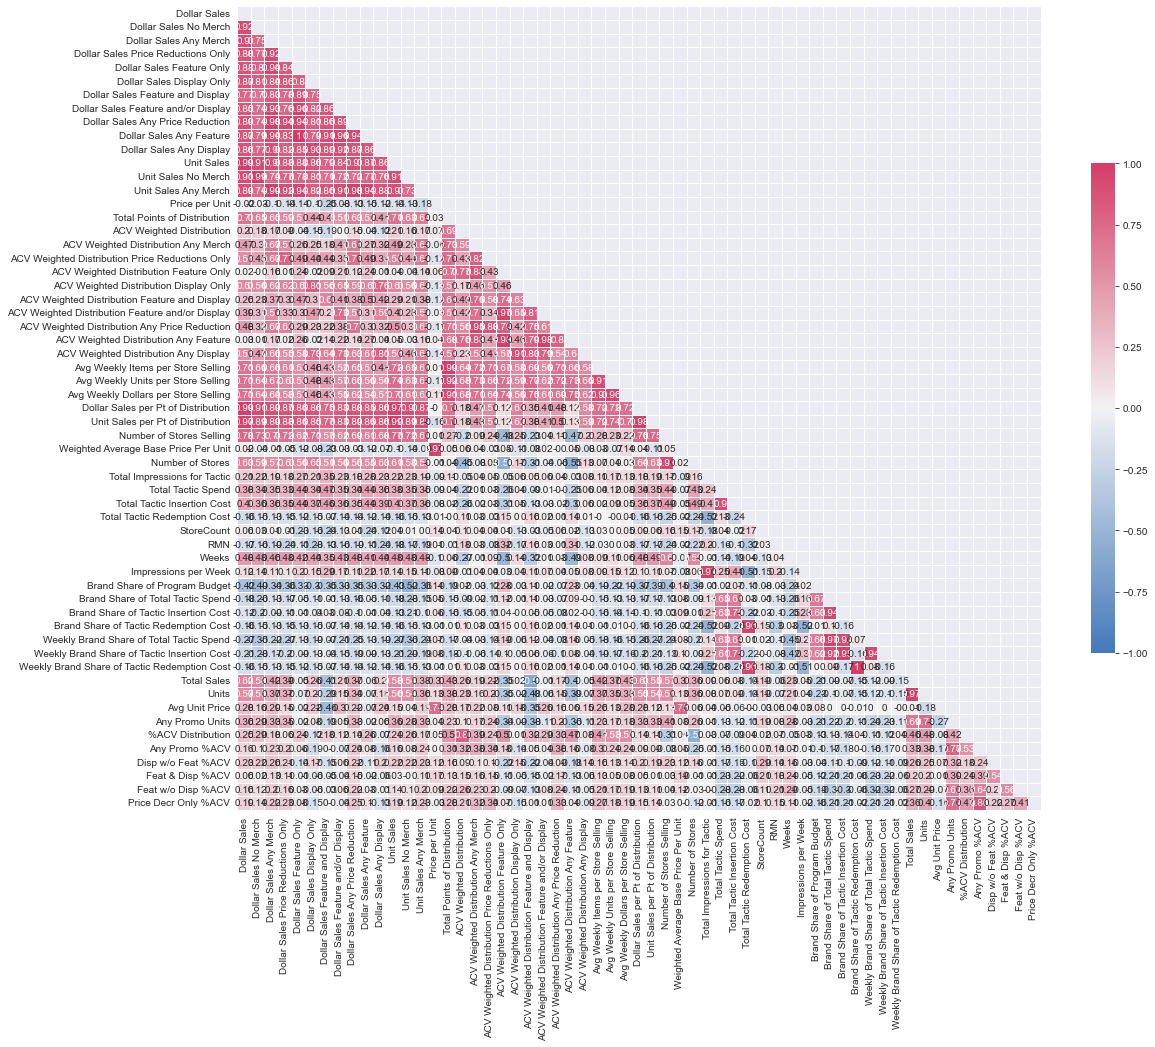

In [100]:
corr = df_num.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

                                             feature           VIF
0                                       Dollar Sales  1.732154e+14
1                              Dollar Sales No Merch  1.072286e+13
2                             Dollar Sales Any Merch  8.115325e+11
3                 Dollar Sales Price Reductions Only  2.583821e+12
4                          Dollar Sales Feature Only  1.005380e+12
5                          Dollar Sales Display Only  2.714647e+12
6                   Dollar Sales Feature and Display  3.042973e+13
7                Dollar Sales Feature and/or Display  3.557346e+12
8                   Dollar Sales Any Price Reduction  6.984578e+04
9                           Dollar Sales Any Feature  2.881474e+11
10                          Dollar Sales Any Display  4.349203e+12
11                                        Unit Sales  7.092283e+13
12                               Unit Sales No Merch  9.623076e+12
13                              Unit Sales Any Merch  9.343568

,Dollar Sales,Dollar Sales No Merch,Dollar Sales Any Merch,Dollar Sales Price Reductions Only,Dollar Sales Feature Only,Dollar Sales Display Only,Dollar Sales Feature and Display,Dollar Sales Feature and/or Display,Dollar Sales Any Price Reduction,Dollar Sales Any Feature,...,Total Sales,Units,Avg Unit Price,Any Promo Units,%ACV Distribution,Any Promo %ACV,Disp w/o Feat %ACV,Feat & Disp %ACV,Feat w/o Disp %ACV,Price Decr Only %ACV
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,...,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,0.317458,0.282034,0.335593,0.277288,0.321186,0.289153,0.279322,0.34678,0.331864,0.324068,...,-0.040339,-0.03000,-0.125763,-0.038983,0.114407,0.029322,-0.075593,-0.073898,-0.027797,0.038305
std,0.476661,0.458038,0.471532,0.462906,0.424025,0.464956,0.421556,0.45654,0.480598,0.428104,...,0.361248,0.35327,0.270014,0.349653,0.273976,0.265453,0.236587,0.260146,0.255343,0.247541
min,-0.400000,-0.400000,-0.460000,-0.410000,-0.350000,-0.440000,-0.520000,-0.44000,-0.490000,-0.390000,...,-0.580000,-0.57000,-0.510000,-0.510000,-0.490000,-0.450000,-0.410000,-0.380000,-0.300000,-0.460000
25%,-0.095000,-0.130000,-0.080000,-0.125000,-0.085000,-0.100000,-0.075000,-0.07000,-0.100000,-0.100000,...,-0.285000,-0.27000,-0.305000,-0.270000,-0.010000,-0.150000,-0.230000,-0.240000,-0.185000,-0.080000
50%,0.240000,0.170000,0.330000,0.140000,0.530000,0.180000,0.460000,0.42000,0.330000,0.540000,...,-0.060000,-0.04000,-0.210000,-0.100000,0.130000,0.010000,-0.130000,-0.160000,-0.120000,0.000000
75%,0.800000,0.730000,0.850000,0.750000,0.710000,0.785000,0.655000,0.84500,0.830000,0.740000,...,0.060000,0.07000,-0.020000,-0.005000,0.285000,0.100000,-0.015000,-0.050000,0.025000,0.080000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


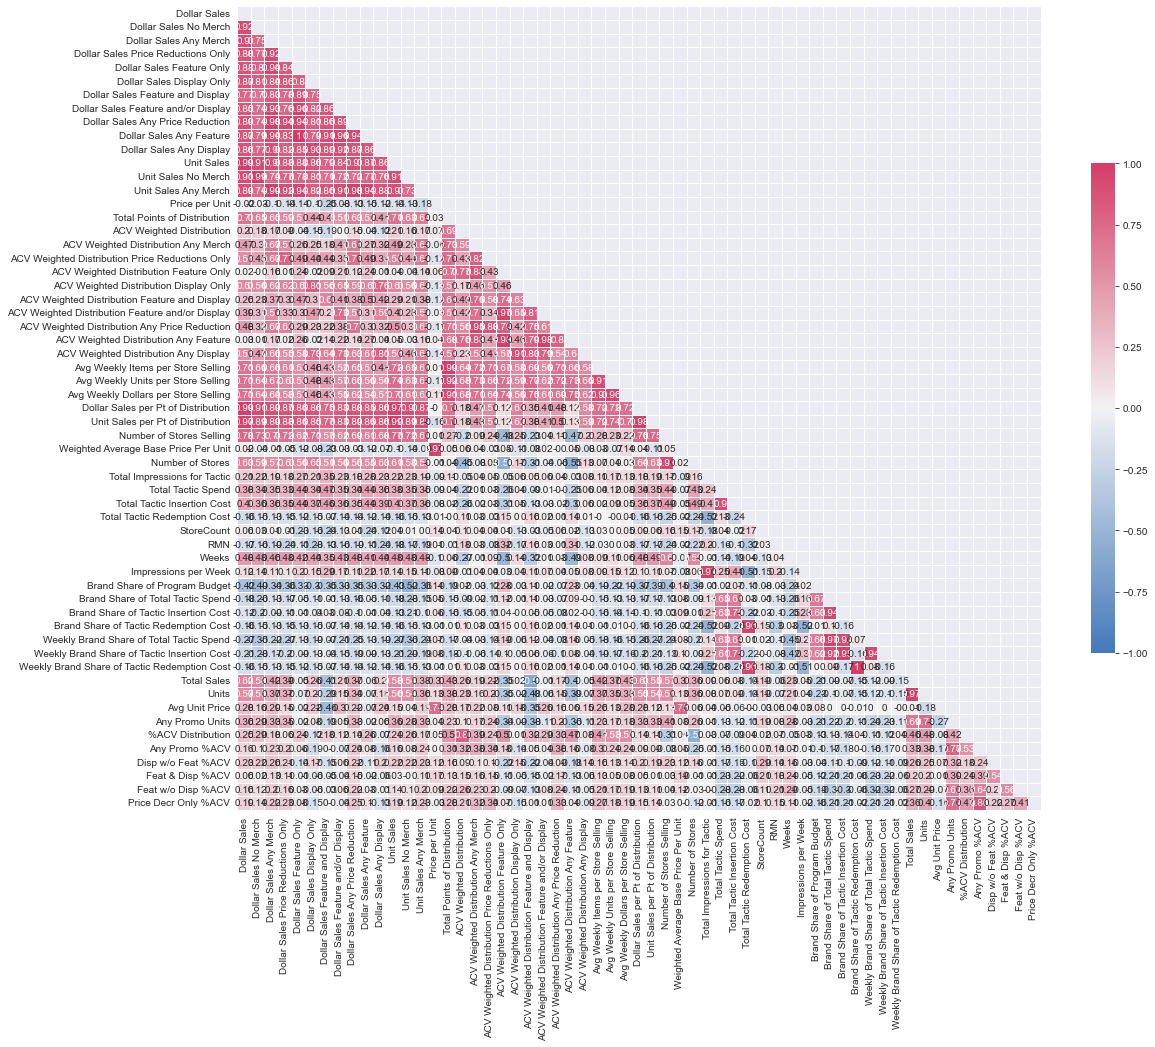

In [101]:
# use VIF along with variable importance to check new dataframes
vif_df = df_num[~df_num.isin([np.nan, np.inf, -np.inf]).any(1)]

X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_vif.describe()

In [102]:
# df_num = df_num.drop(['Units', 'Impressions per Week',
#                       'Any Promo %ACV', '%ACV Distribution'], axis=1)
corr = df_num.corr(method="spearman").round(2)

In [103]:
def imp_plots(target, predictors):
    """Form three importance plots

    :param target:'dependent' component
    :param predictors:'predictive' component
    """
    target = target
    df_all = df_num.dropna().astype(dtype='int32')
    df_all = df_all[predictors + [target]]
    df_train, df_test = train_test_split(df_all, test_size=0.15)
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                max_features=1.0,
                                min_samples_leaf=10, oob_score=True)
    rf.fit(X_train, y_train)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=10,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                           oob_score=True, random_state=None, verbose=0, warm_start=False)
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    imp1 = importances(rf, X_test, y_test)
    plot_importances(imp1, width=16, vscale=4, ax=ax1)

    imp = pd.DataFrame()
    imp['Feature'] = X_train.columns
    imp['Importance'] = rf.feature_importances_
    imp = imp.sort_values('Importance', ascending=False)
    imp2 = imp.set_index('Feature')
    plot_importances(imp2, width=16, vscale=4, ax=ax2)

    perm_importance = permutation_importance(rf, X_test, y_test)
    perm = pd.DataFrame()
    perm['Feature'] = X_test.columns
    perm['Importance'] = perm_importance.importances_mean
    perm = perm.sort_values('Importance', ascending=False)
    perm = perm.set_index('Feature')
    plot_importances(perm, width=16, vscale=4, ax=ax3)
    a = imp1.sort_values(by='Feature')
    b = imp2.sort_values(by='Feature')
    c = perm.sort_values(by='Feature')
    d = (np.abs(a) + np.abs(b) + np.abs(c)).sort_values('Importance',
                                                        ascending=False).mean(axis=1)
    plt.show()
    return d

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

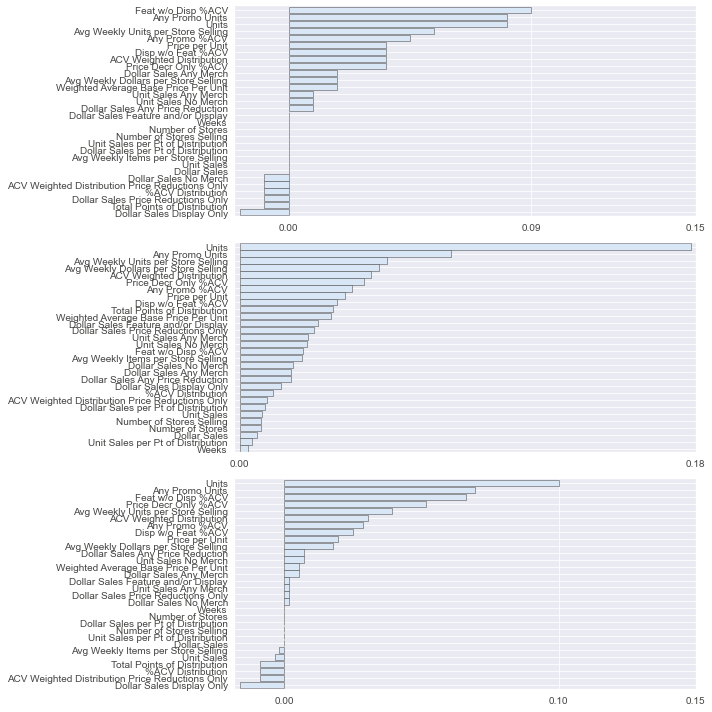

Feature
Units                                              0.360731
Any Promo Units                                    0.234604
Feat w/o Disp %ACV                                 0.180456
Avg Weekly Units per Store Selling                 0.151558
Price Decr Only %ACV                               0.137322
ACV Weighted Distribution                          0.118613
Any Promo %ACV                                     0.118003
Disp w/o Feat %ACV                                 0.099445
Price per Unit                                     0.097359
Avg Weekly Dollars per Store Selling               0.091417
Weighted Average Base Price Per Unit               0.059619
Total Points of Distribution                       0.055252
Dollar Sales Display Only                          0.050504
Dollar Sales Any Merch                             0.043810
Unit Sales No Merch                                0.043085
Dollar Sales Price Reductions Only                 0.040233
Unit Sales Any Merch            

In [104]:
corr_imp = corr[abs(corr['Total Sales'] > .20) & (corr['Total Sales'] < 1.0)]
corr_imp = corr_imp[['Total Sales']]
features = corr_imp.index.tolist()
imp_sales = imp_plots('Total Sales', features)
print(imp_sales)

In [105]:
# corr_imp = corr[abs(corr['Number of UPCs Selling'] > .20) & (corr['Number of UPCs Selling'] < 1.0)]
# corr_imp = corr_imp[['Number of UPCs Selling']]
# features = corr_imp.index.tolist()
# imp_UPC = imp_plots('Number of UPCs Selling', features)
# print(imp_UPC)

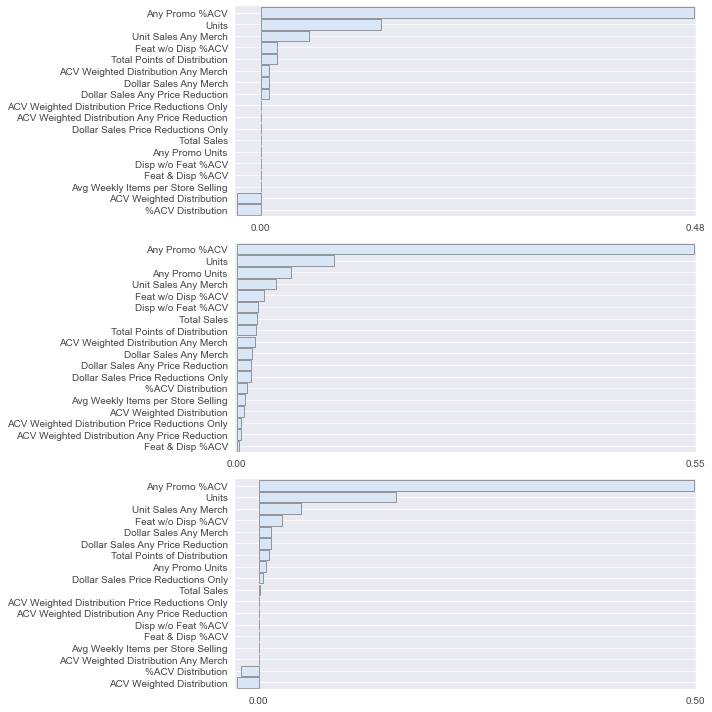

Feature
Any Promo %ACV                                     1.523630
Units                                              0.406838
Unit Sales Any Merch                               0.149154
Feat w/o Disp %ACV                                 0.077204
Any Promo Units                                    0.073449
ACV Weighted Distribution                          0.060492
%ACV Distribution                                  0.059392
Total Points of Distribution                       0.054023
Dollar Sales Any Merch                             0.041118
Dollar Sales Any Price Reduction                   0.040952
ACV Weighted Distribution Any Merch                0.030567
Disp w/o Feat %ACV                                 0.026154
Total Sales                                        0.025864
Dollar Sales Price Reductions Only                 0.022887
Avg Weekly Items per Store Selling                 0.010393
ACV Weighted Distribution Price Reductions Only    0.005591
ACV Weighted Distribution Any Pr

In [106]:
corr_imp = corr[
    abs(corr['Price Decr Only %ACV'] > .20) & (corr['Price Decr Only %ACV'] < 1.0)]
corr_imp = corr_imp[['Price Decr Only %ACV']]
features = corr_imp.index.tolist()
imp_price_decr = imp_plots('Price Decr Only %ACV', features)
print(imp_price_decr)

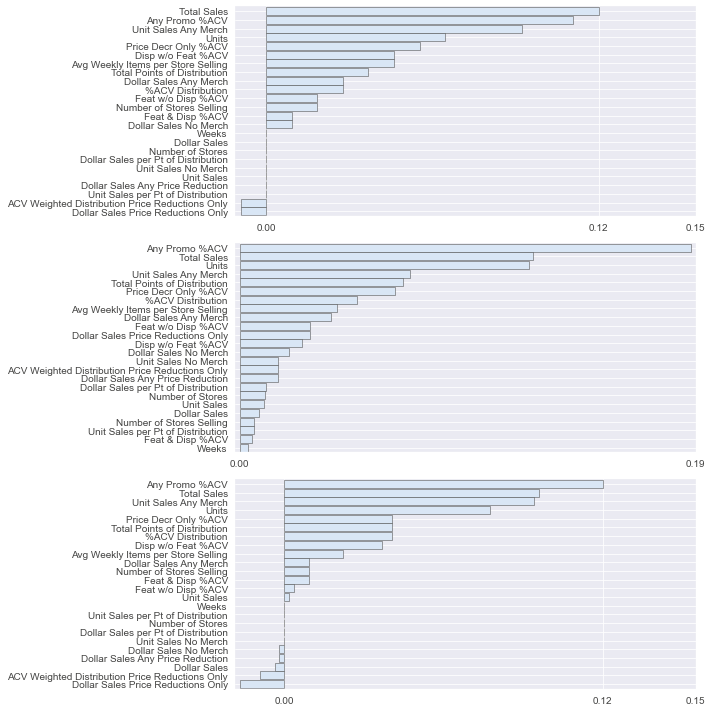

Feature
Any Promo %ACV                                     0.415998
Total Sales                                        0.334021
Units                                              0.261029
Unit Sales Any Merch                               0.253034
Price Decr Only %ACV                               0.159080
Total Points of Distribution                       0.144897
%ACV Distribution                                  0.116094
Avg Weekly Items per Store Selling                 0.107707
Disp w/o Feat %ACV                                 0.106827
Dollar Sales Any Merch                             0.074662
Dollar Sales Price Reductions Only                 0.054886
Feat w/o Disp %ACV                                 0.051429
ACV Weighted Distribution Price Reductions Only    0.034179
Number of Stores Selling                           0.033164
Dollar Sales No Merch                              0.031802
Feat & Disp %ACV                                   0.023389
Dollar Sales Any Price Reduction

In [107]:
corr_imp = corr[abs(corr['Any Promo Units'] > .20) & (corr['Any Promo Units'] < 1.0)]
corr_imp = corr_imp[['Any Promo Units']]
features = corr_imp.index.tolist()
imp_promo_unit = imp_plots('Any Promo Units', features)
print(imp_promo_unit)

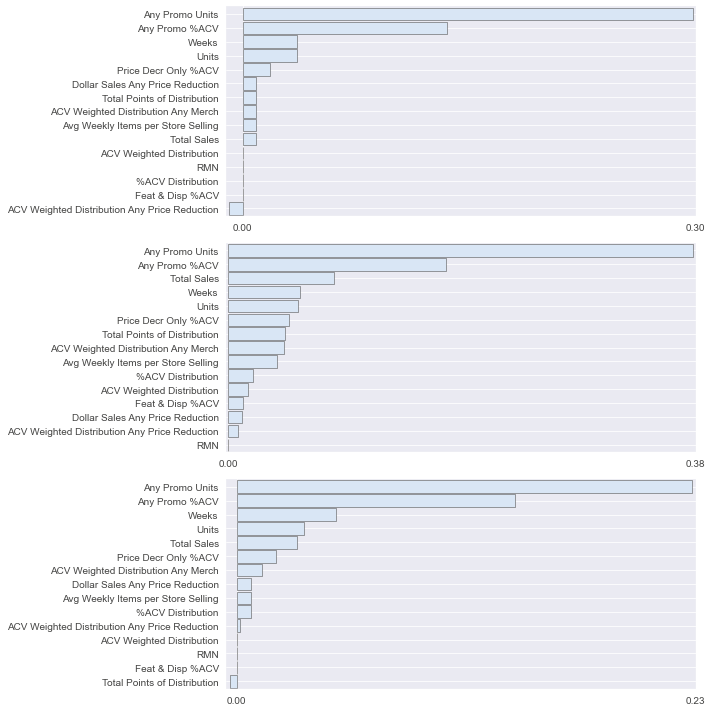

Feature
Any Promo Units                                  0.901928
Any Promo %ACV                                   0.451289
Weeks                                            0.143765
Units                                            0.126250
Total Sales                                      0.125143
Price Decr Only %ACV                             0.086757
ACV Weighted Distribution Any Merch              0.066732
Total Points of Distribution                     0.058562
Avg Weekly Items per Store Selling               0.055195
Dollar Sales Any Price Reduction                 0.027305
%ACV Distribution                                0.027021
ACV Weighted Distribution Any Price Reduction    0.018493
ACV Weighted Distribution                        0.015783
Feat & Disp %ACV                                 0.011687
RMN                                              0.000162
dtype: float64


In [108]:
corr_imp = corr[
    abs(corr['Feat w/o Disp %ACV'] > .20) & (corr['Feat w/o Disp %ACV'] < 1.0)]
corr_imp = corr_imp[['Feat w/o Disp %ACV']]
features = corr_imp.index.tolist()
imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

#### 2. This section continues on to modeling and exploration of modeling techniques

In [109]:
final_vars_cat = ['Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'RMN', 'Tactic Category', 'Brand']

final_vars = ['Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [110]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

Any Promo Units
         sumsquare_error           aic            bic  kl_div
cauchy      1.827237e-11  3.758364e+03 -808822.395752     inf
expon       1.890653e-10  5.836863e+03 -754480.048421     inf
norm        6.482863e-10  7.851772e+03 -725823.073691     inf
uniform     7.906842e-10  2.913060e+03 -721205.218297     inf
gamma       8.139175e-10  6.429196e+07 -720521.660683     NaN
{'cauchy': {'loc': 8423.078776825365, 'scale': 12588.48175268156}}
%ACV Distribution
         sumsquare_error          aic            bic  kl_div
cauchy          0.028209  1677.508330 -316169.401703     inf
norm            0.236293  1165.890949 -266829.351422     inf
gamma           0.237654  1152.410051 -266685.952968     inf
uniform         0.242031   924.370939 -266272.371300     inf
expon           0.248297  1010.702742 -265678.959560     inf
{'cauchy': {'loc': 99.4874360043815, 'scale': 0.9641706204876582}}
Feat w/o Disp %ACV
         sumsquare_error          aic            bic    kl_div
gamma       

##### 2.1 Here I tested the Bambi package to establish a baseline,
##### but it slows down the modeling process

In [111]:
df_nostr = df[final_vars]
df_nostr = df_nostr[df_nostr['Total Sales'] > 0.0]
df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')

df_nostr['TotalSales'] = np.log(df_nostr['TotalSales'])

C:\Users\norri\AppData\Local\Temp/ipykernel_8392/2114850551.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')


In [112]:
bmb_model = bmb.Model('TotalSales ~ '
                      ' FeatwoDispACV + PriceDecrOnlyACV + DispwoFeatACV'
                      , data=df_nostr, dropna=False)

bmb_fitted = bmb_model.fit(draws=3000, tune=3000, chains=4)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, FeatwoDispACV, PriceDecrOnlyACV, DispwoFeatACV, TotalSales_sigma]
INFO:pymc:NUTS: [Intercept, FeatwoDispACV, PriceDecrOnlyACV, DispwoFeatACV, TotalSales_sigma]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 45 seconds.
INFO:pymc:Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 45 seconds.


##### 2.3 Here I test and get diagnostics for this model
##### and to prepare for the more complicated model

                    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept         11.756  0.017  11.725   11.788        0.0      0.0   
FeatwoDispACV      0.005  0.000   0.004    0.006        0.0      0.0   
PriceDecrOnlyACV   0.013  0.000   0.013    0.014        0.0      0.0   
DispwoFeatACV      0.074  0.002   0.071    0.078        0.0      0.0   
TotalSales_sigma   1.589  0.007   1.575    1.603        0.0      0.0   

                  ess_bulk  ess_tail  r_hat  
Intercept          20005.0    9916.0    1.0  
FeatwoDispACV      16292.0   10214.0    1.0  
PriceDecrOnlyACV   16673.0   10496.0    1.0  
DispwoFeatACV      21880.0    9823.0    1.0  
TotalSales_sigma   20821.0    9911.0    1.0  
<xarray.Dataset>
Dimensions:           ()
Data variables:
    Intercept         float64 2e+04
    FeatwoDispACV     float64 1.629e+04
    PriceDecrOnlyACV  float64 1.667e+04
    DispwoFeatACV     float64 2.188e+04
    TotalSales_sigma  float64 2.082e+04


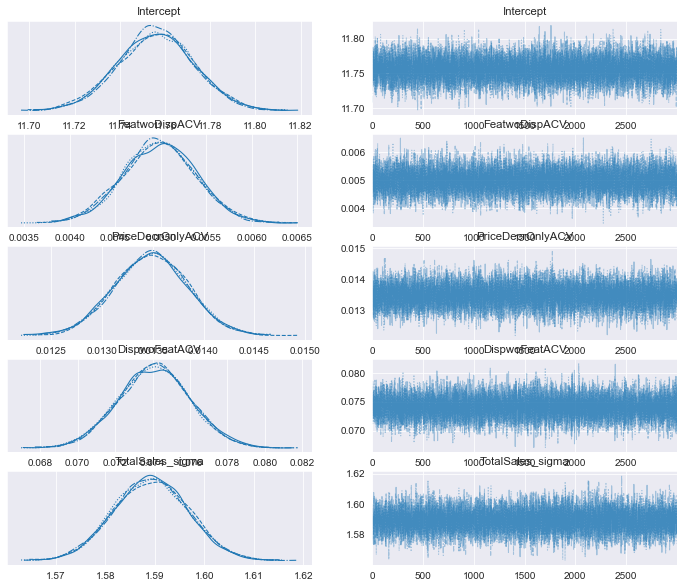

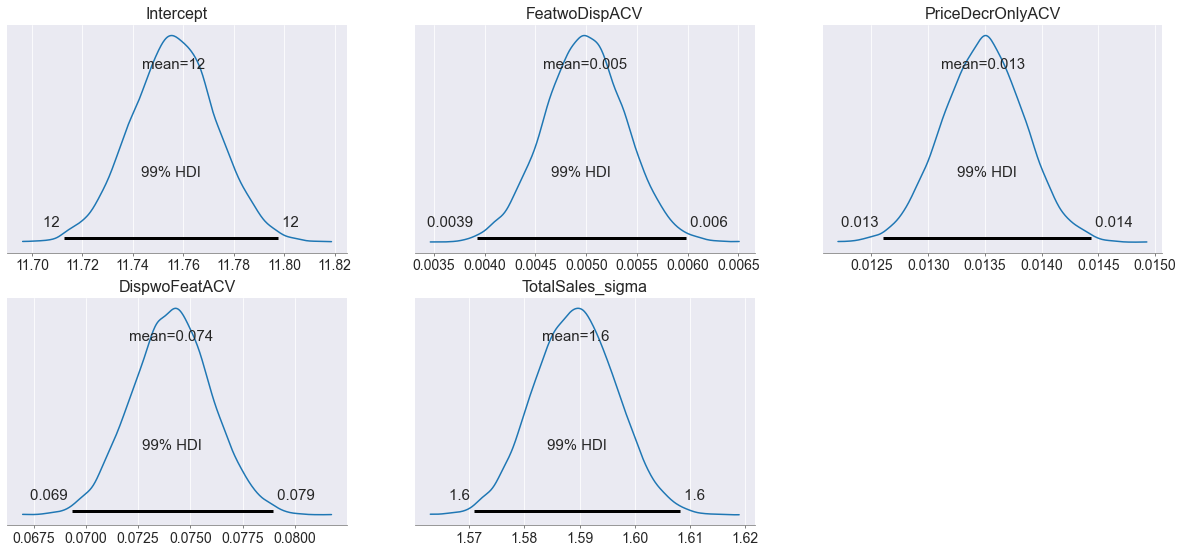

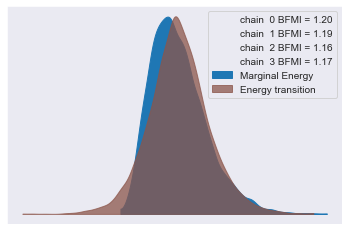

In [113]:
az.plot_trace(bmb_fitted)
print(az.summary(bmb_fitted))
print(az.ess(bmb_fitted))
az.plot_posterior(bmb_fitted, hdi_prob=0.99)
az.plot_energy(bmb_fitted);

##### 2.4 Note the above graph and compare it to the
##### graph at the end. Having each chain closer to one
##### is the ideal

In [114]:
df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

The following two charts show that many Tactic Category observations have dropped and two categories have also dropped.

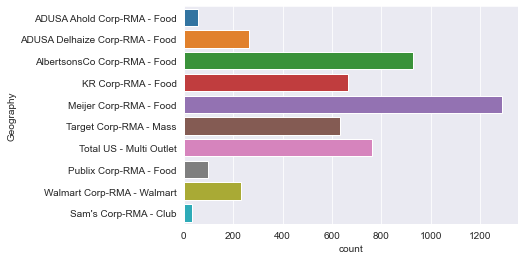

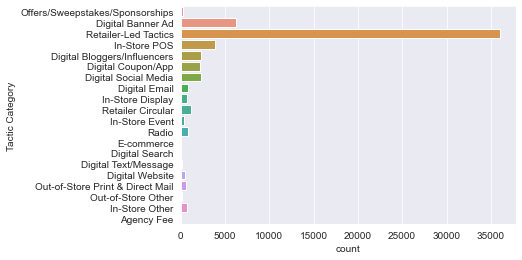

Original number of obs and Tactic Categories
59003
20


In [115]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

print('Original number of obs and Tactic Categories')
print(df['Tactic Category'].count())
print(df['Tactic Category'].nunique())

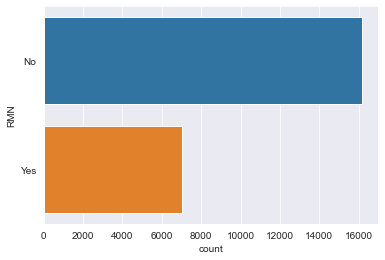

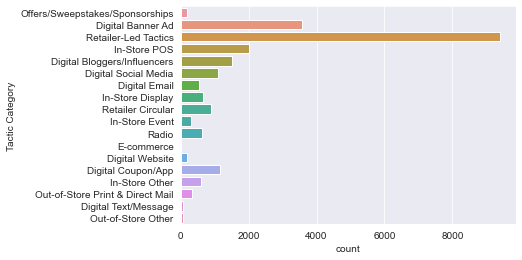

Number of obs, new tactics, and new displays
23214
18
46


In [116]:
for col in df_final_cat.select_dtypes(include='object'):
    if df_final_cat[col].nunique() <= 25:
        sns.countplot(y=col, data=df_final_cat)
        plt.show()

print('Number of obs, new tactics, and new displays')
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

In [117]:
tt.config.floatX = 'float64'

df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

df_final_cat['Total Sales'] = np.log(df_final_cat['Total Sales'])

price_decr_idxs, price_decr = pd.factorize(df_final_cat['Price Decr Only %ACV'],
                                           sort=True)
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs)), 'price_decrease': price_decr}

#### 3. Hierarchical Model with diagnostics

In [118]:
with pm.Model(coords=coords) as h_model:
    tactic_idx = pm.Data("Tactic Category", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("Brand", brand_idxs, dims="obs_idx")
    price_decr = pm.Data("Price Decrease Only", price_decr_idxs, dims="obs_idx")

    # Tactic Category hyperpriors parameters:
    hp_b_0 = pm.Normal("hp_b_0", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    hp_b_1 = pm.Normal("hp_b_1", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)

    # Brand hyperpriors parameters
    hp_b_2 = pm.Normal("hp_b_2", mu=0.0, sigma=5.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    hp_b_3 = pm.Normal("hp_b_3", mu=0.0, sigma=1.0)
    sigma_d = pm.Exponential("sigma_d", 0.5)

    hp_b_4 = pm.Normal("hp_b_4", mu=0.5, sigma=.3)

    # estimates of independent intercepts and interactions of intercepts
    b_0 = pm.Normal("tactic_int", mu=hp_b_0, sigma=sigma_a, dims="tactics")
    b_1 = pm.Normal("tactic_slope", mu=hp_b_1, sigma=sigma_b, dims="tactics")

    b_2 = pm.Normal("display_int", mu=hp_b_2, sigma=sigma_c, dims="brand")
    b_3 = pm.Normal("display_slope", mu=hp_b_3, sigma=sigma_d, dims="brand")

    price_decr_est = hp_b_4 * price_decr

    # estimate of total sales using intercepts
    sales_est_1 = b_0[tactic_idx] + b_1[tactic_idx] * brand_idx
    sales_est_2 = b_2[brand_idx] + b_3[brand_idx] * tactic_idx
    sales_est = sales_est_1 + sales_est_2 + price_decr_est

    # Data likelihood
    epsilon = pm.Exponential("noise", 1.0)
    Total_Sales = pm.Normal(
            "Log_Total_Sales", mu=sales_est, sigma=epsilon,
            observed=df_final_cat['Total Sales'], dims="obs_idx")

with h_model:
    h_trace = pm.sample(draws=3000, init='advi+adapt_diag', chains=4,
                                   cores=4, tune=3000,
                                   target_accept=0.8, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 65200
INFO:pymc3.variational.inference:Convergence achieved at 65200
Interrupted at 65,199 [32%]: Average Loss = 3.2865e+09
INFO:pymc3.variational.inference:Interrupted at 65,199 [32%]: Average Loss = 3.2865e+09
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]
INFO:pymc3:NUTS: [noise, display_slope, display_int, tactic_slope, tactic_int, hp_b_4, sigma_d, hp_b_3, sigma_c, hp_b_2, sigma_b, hp_b_1, sigma_a, hp_b_0]


Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 6782 seconds.
INFO:pymc3:Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 6782 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain contains only diverging samples. The model is probably misspecified.
ERROR:pymc3:The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.48915164339300105, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for s

In [119]:
with h_model:
    model_ppc = pm.sample_posterior_predictive(
            h_trace, h_model)

TypeError: '<' not supported between instances of 'Model' and 'int'

In [120]:
print('Model R-Squared')
print(az.r2_score(df_final_cat['Total Sales'].values, model_ppc['Log_Total_Sales']))
def score_model(trace,y,model_name):
    """

    :param trace: trace from PyMC3 plot
    :param y: samples
    :param model_name: model from PyMC3
    """
    post_ppc = pm.sample_posterior_predictive(trace, samples=20841,
                                         model=model_name)
    pred = post_ppc['Log_Total_Sales'].mean(axis=0)
    mse = np.sqrt(mean_squared_error(y, pred))
    print('The Mean Squared Error')
    print(mse)

score_model(h_trace, df_final_cat['Total Sales'], h_model)

print('Trace Summary and Effective Sample Size')
print(az.summary(h_trace, kind='stats'))
print(az.summary(h_trace, kind='diagnostics'))
az.plot_posterior(h_trace, hdi_prob=0.99)
az.plot_energy(h_trace)
plt.show()
print('Bayesian fraction of missing information')
print(az.bfmi(h_trace))
az.plot_forest(h_trace, kind='ridgeplot')

Model R-Squared


NameError: name 'model_ppc' is not defined

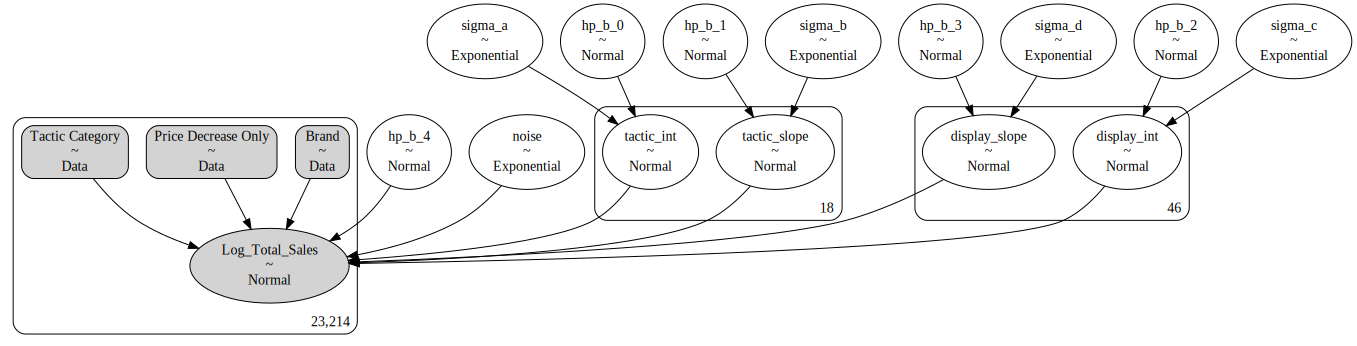

In [121]:
pm.model_to_graphviz(h_model)

In [122]:
h_trace.to_csv(index=False)

AttributeError: 'InferenceData' object has no attribute 'to_csv'